https://kornia.github.io/tutorials/nbs/image_points_transforms.html

In [1]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename



download_image("https://github.com/kornia/data/raw/main/arturito.jpg")


'arturito.jpg'

In [7]:
import numpy as np 
import torch
from PIL import Image

import kornia as K
import torch
from matplotlib import pyplot as plt

img = Image.open('arturito.jpg')
img = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
img = img[None]
img.shape

torch.Size([1, 3, 144, 256])

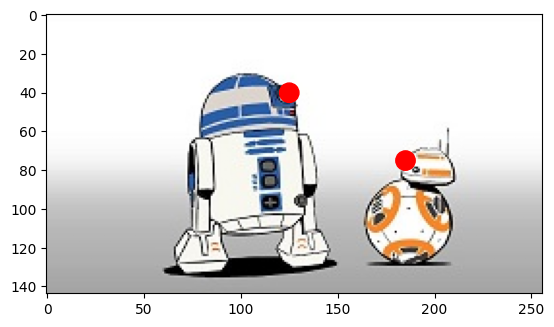

In [8]:
coords = torch.tensor([[[125, 40.0], [185.0, 75.0]]])  # BxNx2 [x,y]

fig, ax = plt.subplots()

ax.add_patch(plt.Circle((coords[0, 0, 0], coords[0, 0, 1]), color="r"))
ax.add_patch(plt.Circle((coords[0, 1, 0], coords[0, 1, 1]), color="r"))

ax.imshow(K.tensor_to_image(img))

None


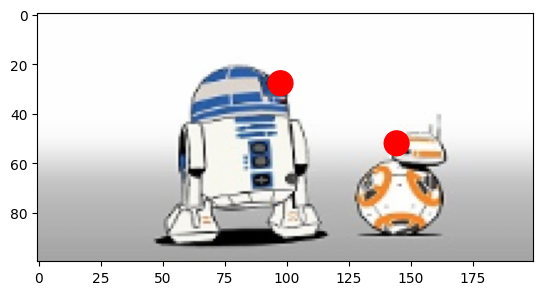

In [9]:
resize_op = K.augmentation.AugmentationSequential(
    K.augmentation.Resize((100, 200), antialias=True), data_keys=["input", "keypoints"]
)

print(resize_op.transform_matrix)

img_resize, coords_resize = resize_op(img, coords)


fig, ax = plt.subplots()

ax.add_patch(plt.Circle((coords_resize[0, 0, 0], coords_resize[0, 0, 1]), color="r"))
ax.add_patch(plt.Circle((coords_resize[0, 1, 0], coords_resize[0, 1, 1]), color="r"))

ax.imshow(K.tensor_to_image(img_resize))

None
torch.Size([1, 2, 2])


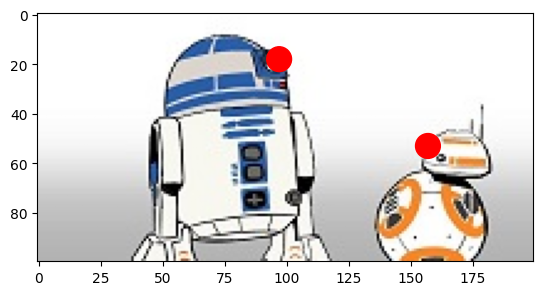

In [23]:
crop_op = K.augmentation.AugmentationSequential(K.augmentation.CenterCrop((100, 200)), data_keys=["input", "keypoints"])
print(crop_op.transform_matrix)

img_resize, coords_resize = crop_op(img, coords)
print(coords.shape)   # [batch=1, num_points=2, xy=2]


fig, ax = plt.subplots()

ax.add_patch(plt.Circle((coords_resize[0, 0, 0], coords_resize[0, 0, 1]), color="r"))
ax.add_patch(plt.Circle((coords_resize[0, 1, 0], coords_resize[0, 1, 1]), color="r"))

ax.imshow(K.tensor_to_image(img_resize))

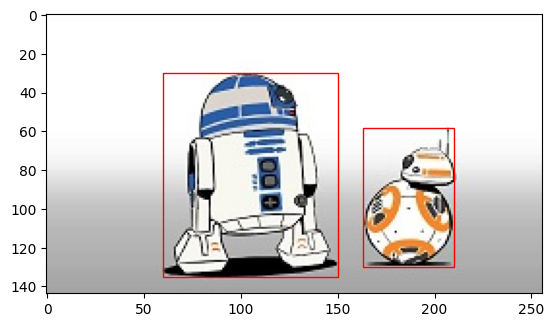

In [80]:
from kornia.constants import DataKey

rscrop_op = K.augmentation.AugmentationSequential(
    K.augmentation.RandomResizedCrop((100, 200), scale=(0.66, 1.0), ratio=(0.75, 1.333), p=1),
    data_keys=["input", DataKey.BBOX_XYXY]
)

def show_with_bbox(img: torch.Tensor, bbox_xyxy: torch.Tensor, ow, oh):
    bbox_xywh = bbox_xyxy.clone()
    for xywh, xyxy in zip(bbox_xywh, bbox_xyxy):
        xywh[2:] -= xyxy[:2]
        xywh = xywh.numpy() * np.array([ow, oh, ow, oh])
        plt.gca().add_patch(plt.Rectangle(xywh[:2], xywh[2], xywh[3], fill=False, edgecolor="r"))
        plt.imshow(K.tensor_to_image(img))
    plt.show()

ow, oh = 256, 144
bbox = torch.tensor([
    [60, 30, 150, 135],
    [163, 58, 210, 130]
]) / torch.tensor([ow, oh, ow, oh])[None]
bbox = bbox[None]
show_with_bbox(img[0], bbox[0], ow, oh)

In [82]:
(bbox * torch.tensor([ow, oh, ow, oh])[None]).shape

torch.Size([1, 2, 4])

torch.Size([1, 3, 100, 200]) torch.Size([1, 2, 4])
tensor([[[0.2344, 0.2083, 0.5859, 0.9375],
         [0.6367, 0.4028, 0.8203, 0.9028]]]) tensor([[[0.1221, 0.1442, 0.4884, 0.6490],
         [0.5413, 0.2788, 0.7326, 0.6250]]])


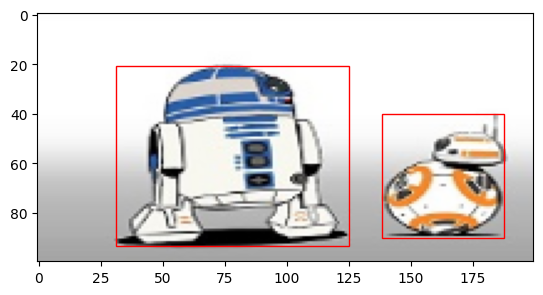

In [84]:
img_rsc, bbox_rsc = rscrop_op(img, bbox * torch.tensor([ow, oh, ow, oh])[None])
bbox_rsc = bbox_rsc / torch.tensor([ow, oh, ow, oh])
print(img_rsc.shape, bbox_rsc.shape)
print(bbox, bbox_rsc)
show_with_bbox(img_rsc[0], bbox_rsc[0], ow, oh)